In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle                      
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import matplotlib.gridspec as gridspec
from random import randint

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#Creating labels for the dataset
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

print(class_names_label)

IMAGE_SIZE = (150, 150)

{'mountain': 0, 'street': 1, 'glacier': 2, 'buildings': 3, 'sea': 4, 'forest': 5}


In [3]:
#Initial dataset
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    seg_train = r'C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_train'
    seg_test = r"C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_test"
    
    datasets = [seg_train, seg_test]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_train


100%|██████████| 2382/2382 [00:02<00:00, 910.49it/s]


Loading C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_test


100%|██████████| 501/501 [00:00<00:00, 805.16it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)


# Data Exploration 

- Visualising the number of training and testing data 

- Visualising the proportion of each observed category within the data set


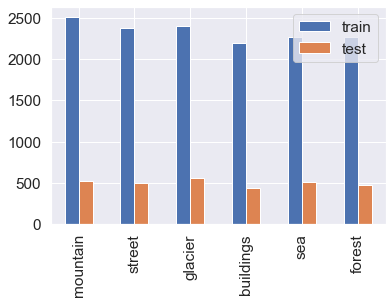

In [6]:
#Visualise the number of images in train and test dataset 
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

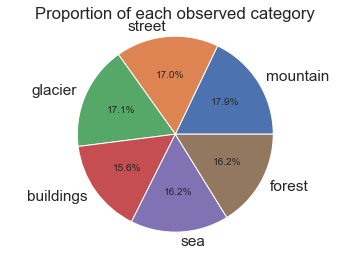

In [7]:
#Visualise the proportion of images based on train data 
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [8]:
#For the cleaned data set
def load_data():
    
    seg_train_cleaned = r'C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_train_cleaned'
    seg_test_cleaned =  r"C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_test_cleaned"
    datasets = [seg_train_cleaned,seg_test_cleaned]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [9]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_train_cleaned


100%|██████████| 2000/2000 [00:01<00:00, 1168.39it/s]


Loading C:\Users\ziyan\OneDrive\NTU BCG Y1S2 2022\SC1015 Intro to DSAI\SC1015 project\seg_test_cleaned


100%|██████████| 500/500 [00:00<00:00, 829.00it/s]


In [10]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

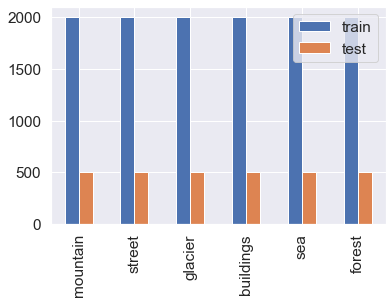

In [11]:
#Visualise the number of images in train and test dataset 
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

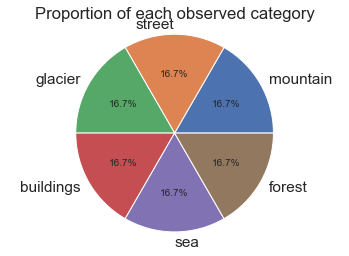

In [12]:
#Visualise the proportion of images based on train data 

plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

# Scale the dataset 
- When using the image as it is and passing through a Deep Neural Network, the computation of high numeric values may become more complex.
- To reduce this we can normalize the values to range from 0 to 1. In this way, the numbers will be small and the computation becomes easier and faster. As the pixel values range from 0 to 256, apart from 0 the range is 255. So dividing all the values by 255 will convert it to range from 0 to 1

In [13]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Visualize the dataset
### Display a random image from the training set.

In [14]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

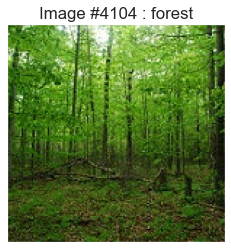

In [15]:
display_random_image(class_names, train_images, train_labels)


### Display the first 25 images from the training set 

In [16]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

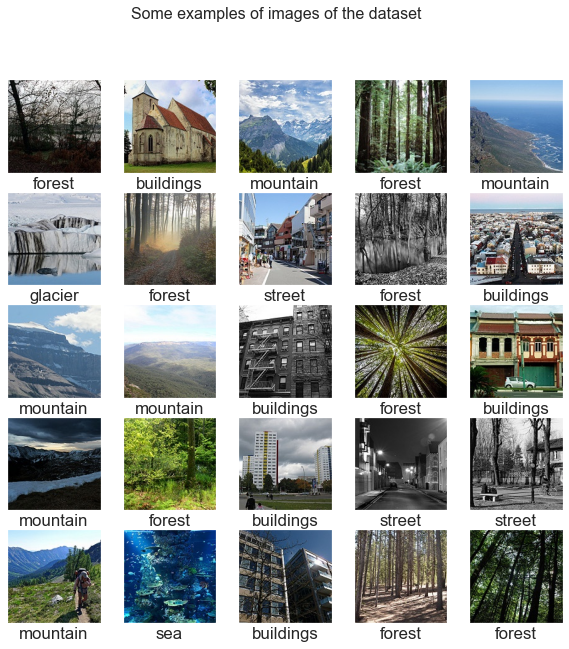

In [17]:
display_examples(class_names, train_images, train_labels)


# Base Model for our Convolutional neural network

- Build the model,
- Compile the model,
- Train / fit the data to the model, 
- Evaluate the model on the testing set and validation set,
- Carry out an error analysis of our model.


Our model consist of different layers such as:

- Conv2D: (32 filters of size 3 by 3)  the filters will slide through the input image to "extract" various features of the image
- MaxPooling2D: The images get half sized to a 2x2 layer. 
- Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
- Relu : given a value x, returns max(x, 0).
- Softmax: 6 output neurons, probability that the image belongs to one of the classes.

We will start running our model with 20 epoches. 

In [18]:
#Baseline model1
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'), 
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(6, activation=tf.nn.softmax) 
])
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [19]:
#This is where we compile the model
model1.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Fit the model & include validation split
history1 = model1.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
75/75 [==============================] - 92s 1s/step - loss: 1.2002 - accuracy: 0.5690 - val_loss: 0.8217 - val_accuracy: 0.7042
Epoch 2/20
75/75 [==============================] - 89s 1s/step - loss: 0.6992 - accuracy: 0.7456 - val_loss: 0.7336 - val_accuracy: 0.7400
Epoch 3/20
75/75 [==============================] - 89s 1s/step - loss: 0.5559 - accuracy: 0.8014 - val_loss: 0.6992 - val_accuracy: 0.7458
Epoch 4/20
75/75 [==============================] - 88s 1s/step - loss: 0.4470 - accuracy: 0.8429 - val_loss: 0.6214 - val_accuracy: 0.7875
Epoch 5/20
75/75 [==============================] - 87s 1s/step - loss: 0.3362 - accuracy: 0.8896 - val_loss: 0.6543 - val_accuracy: 0.7783
Epoch 6/20
75/75 [==============================] - 87s 1s/step - loss: 0.2368 - accuracy: 0.9245 - val_loss: 0.7335 - val_accuracy: 0.7733
Epoch 7/20
75/75 [==============================] - 88s 1s/step - loss: 0.1617 - accuracy: 0.9546 - val_loss: 0.7387 - val_accuracy: 0.7733
Epoch 8/20
75/75 [==

In [21]:
def plot_accuracy_loss(history):
    """
        Plot accuracy & loss function of training process of neural network 
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy of train vs validation
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function of train vs validation
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    # Show plots
    plt.legend()
    plt.show()

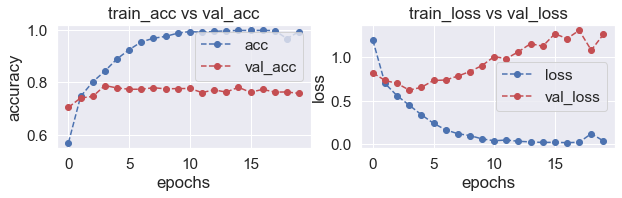

In [22]:
plot_accuracy_loss(history1)

In [23]:
test_loss = model1.evaluate(test_images, test_labels)

94/94 [==============================] - 6s 63ms/step - loss: 1.2161 - accuracy: 0.7463


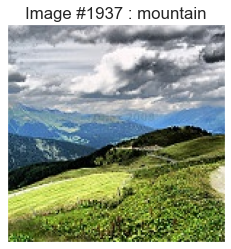

In [24]:
predictions = model1.predict(test_images)     # Probability Vectors
pred_labels = np.argmax(predictions, axis = 1) # Extract highest probability
display_random_image(class_names, test_images, pred_labels)

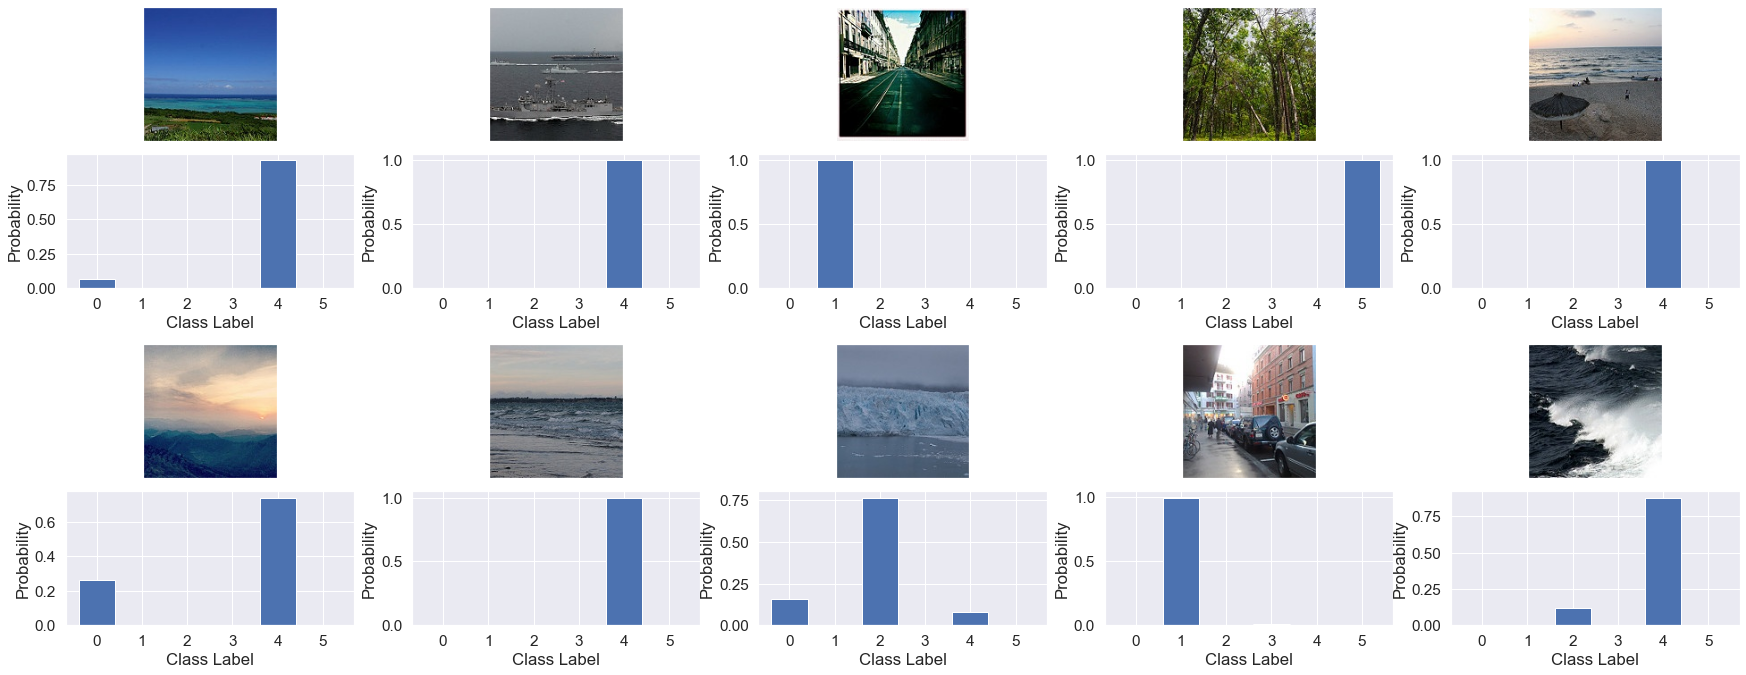

In [25]:
# Function to visualise probabilities of image being classified into various categories

fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(10):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(test_images))
    pred_image = np.array([test_images[rnd_number]])
    pred_class = np.argmax(pred_image, axis = 1)
    pred_prob = model1.predict(pred_image).reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            #ax.set_title(pred_class[0])
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)

        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)
            ax.set_xticks([0,1,2,3,4,5])
            # Set common labels
            ax.set_xlabel('Class Label')
            ax.set_ylabel('Probability')

plt.show()

# Error analysis


We can try to understand on which kind of images the classifier has trouble.

In [26]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Show 25 random images wrongly labelled by classifier & their wrong labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

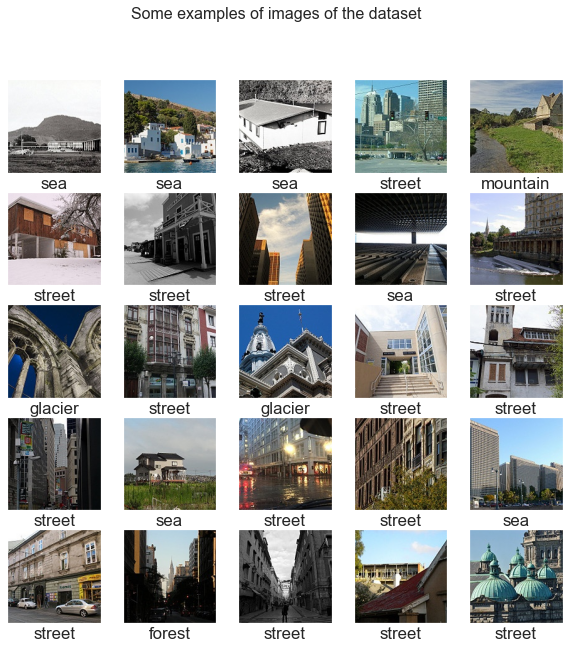

In [27]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

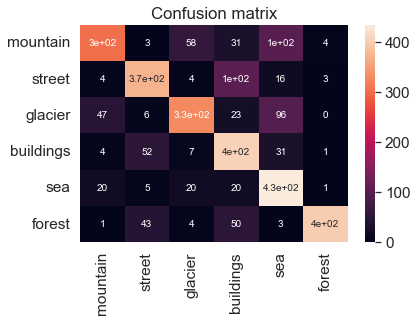

In [28]:
# Plot heatmap to visualise misclassification numerically, see which images are significantly misclassified

CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## Conclusion: Model works most poorly for images of seas & streets.


Model works very well at predicting forests accurately.

Seas are often wrongly classified as mountains. This is understandable as images of seas may include mountains in the background.

Images of buildings are also often classified as streets. Again, images of buildings may include streets, which makes it hard for the model to classify correctly.

# Model 2 

For our second model Dropout Layers are introduced. 
- Dropout: randomly killing each neuron in a layer of a training set with probability p

In [29]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),  
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
]) #
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 32)       

In [30]:
model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
history2 = model2.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
75/75 [==============================] - 104s 1s/step - loss: 1.6733 - accuracy: 0.3754 - val_loss: 1.2368 - val_accuracy: 0.5817
Epoch 2/20
75/75 [==============================] - 99s 1s/step - loss: 1.1429 - accuracy: 0.5558 - val_loss: 1.0851 - val_accuracy: 0.6212
Epoch 3/20
75/75 [==============================] - 99s 1s/step - loss: 1.0352 - accuracy: 0.6050 - val_loss: 0.9843 - val_accuracy: 0.6504
Epoch 4/20
75/75 [==============================] - 100s 1s/step - loss: 0.9420 - accuracy: 0.6380 - val_loss: 0.9049 - val_accuracy: 0.6963
Epoch 5/20
75/75 [==============================] - 100s 1s/step - loss: 0.8432 - accuracy: 0.6822 - val_loss: 0.8340 - val_accuracy: 0.7221
Epoch 6/20
75/75 [==============================] - 102s 1s/step - loss: 0.7763 - accuracy: 0.7085 - val_loss: 0.7261 - val_accuracy: 0.7425
Epoch 7/20
75/75 [==============================] - 102s 1s/step - loss: 0.7074 - accuracy: 0.7375 - val_loss: 0.7918 - val_accuracy: 0.7229
Epoch 8/20
75/7

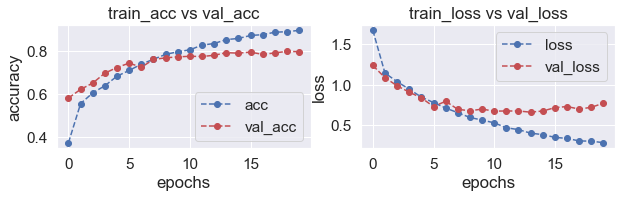

In [32]:
plot_accuracy_loss(history2)

In [33]:
test_loss = model2.evaluate(test_images, test_labels)

94/94 [==============================] - 6s 64ms/step - loss: 0.7845 - accuracy: 0.7807


In [34]:
predictions = model2.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

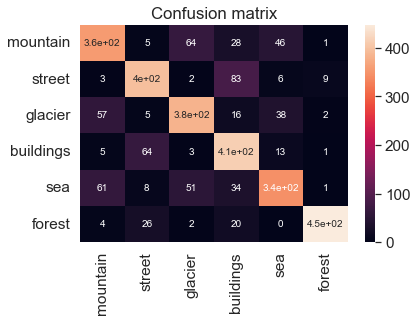

In [35]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

# Model 3 

For our third model more Convulational blocks with dropout Layers are introduced. 

In [36]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),  
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 36, 36, 32)       

In [37]:
model3.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
history3 = model3.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
75/75 [==============================] - 117s 2s/step - loss: 1.4037 - accuracy: 0.4384 - val_loss: 1.1628 - val_accuracy: 0.5842
Epoch 2/20
75/75 [==============================] - 111s 1s/step - loss: 1.0560 - accuracy: 0.5868 - val_loss: 1.0100 - val_accuracy: 0.6375
Epoch 3/20
75/75 [==============================] - 110s 1s/step - loss: 0.9182 - accuracy: 0.6478 - val_loss: 0.8296 - val_accuracy: 0.7208
Epoch 4/20
75/75 [==============================] - 111s 1s/step - loss: 0.7985 - accuracy: 0.7054 - val_loss: 0.7860 - val_accuracy: 0.7321
Epoch 5/20
75/75 [==============================] - 111s 1s/step - loss: 0.7571 - accuracy: 0.7206 - val_loss: 0.7071 - val_accuracy: 0.7658
Epoch 6/20
75/75 [==============================] - 111s 1s/step - loss: 0.6877 - accuracy: 0.7500 - val_loss: 0.6631 - val_accuracy: 0.7567
Epoch 7/20
75/75 [==============================] - 111s 1s/step - loss: 0.6658 - accuracy: 0.7596 - val_loss: 0.5999 - val_accuracy: 0.7992
Epoch 8/20
75

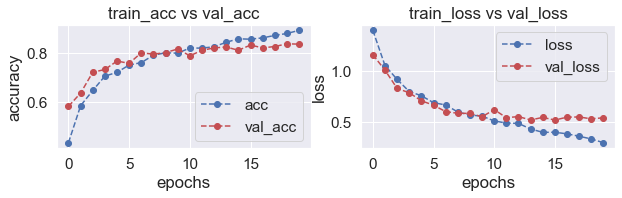

In [39]:
plot_accuracy_loss(history3)

In [40]:
test_loss = model3.evaluate(test_images, test_labels)

94/94 [==============================] - 6s 68ms/step - loss: 0.5266 - accuracy: 0.8360


In [41]:
predictions = model3.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

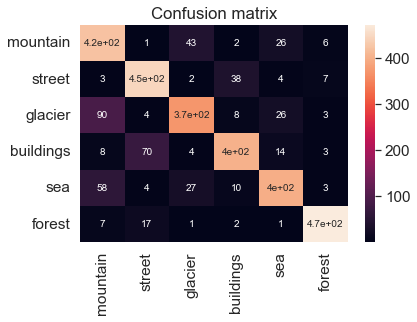

In [42]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()